<a href="https://colab.research.google.com/gist/KhawajaMuddassar/26e7fec0f6fb8372801f96a5406713d5/pix2pix-gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pix2Pix GAN**

In [1]:
!pip install -q --upgrade torch_snippets gdown torchsummary
import os, sys, torch, torchvision, gdown, zipfile, cv2, numpy as np, torch.nn as nn, time,glob
from glob import glob as Glob
from matplotlib import pyplot as plt
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, clear_output
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch_snippets.torch_loader import T, Report
from torch_snippets.loader import read, Blank, resize,show
from torch_snippets.bb_utils import randint
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToPILImage
from torchsummary import summary


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.7/218.7 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 53.7 MB/s eta 0:00:00


In [2]:
class Preprocessor:
    def __init__(self, FileID='1aXCrXErLBMmWiSM9ifgme1WqZYETAY_E'):
        self.FileID = FileID
        self.url = f'https://drive.google.com/uc?id={self.FileID}'
        self.Zipfile = 'Fine-Grained-SBIR-Datasets.zip'
        self.TargetFolder = '/content/'
        self.folder_paths = {
            'Chair': '/content/Fine-Grained-SBIR-Datasets/ChairV2/trainB',
            'Shoes': '/content/Fine-Grained-SBIR-Datasets/ShoeV2/trainB' }
        self.train_dl = None
        self.val_dl = None
    def GetDataset(self):
        gdown.download(self.url, self.Zipfile, quiet=False)
        if not os.path.exists(self.TargetFolder):
            os.makedirs(self.TargetFolder)
    def Unzip(self):
        with zipfile.ZipFile(self.Zipfile, 'r') as zipref:
            zipref.extractall(self.TargetFolder)
            print(f'\nDataset downloaded and extracted successfully!')
    def RemoveZip(self):
        os.remove(self.Zipfile)
        print(f'Compressed file {self.Zipfile} removed!\n')
    def Run(self):
        self.GetDataset()
        self.Unzip()
        self.RemoveZip()
    def create_category_selector(self):
        category_dropdown = widgets.Dropdown(
            options=list(self.folder_paths.keys()),
            value='Chair', description='Select:',disabled=False,)
        instruction_label = widgets.Label(value="Please choose a category for image translation:")
        def on_category_change(change): # Callback
            clear_output(wait=True)
            display(instruction_label)
            display(category_dropdown)
            category_input = change.new
            if category_input not in self.folder_paths:
                print(f"Category '{category_input}' not found!")
                return
            data_splitter = DataSplitter(self, category_input)
            train_items, val_items,self.train_dl, self.val_dl = data_splitter.split_data()
            data_splitter.display_split_sample(train_items, val_items, self.train_dl, self.val_dl)
        category_dropdown.observe(on_category_change, names='value')
        display(instruction_label)
        display(category_dropdown)

class SBIRDatasets(Dataset):
    def __init__(self, items, img_size=256):
        self.img_size = img_size
        self.items = items
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    def __detect_edges(self, img):
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img_gray = cv2.bilateralFilter(img_gray, 5, 50, 50)
        img_gray_edges = cv2.Canny(img_gray,45,100)
        img_gray_edges = cv2.bitwise_not(img_gray_edges) #invert black/white
        img_edges = cv2.cvtColor(img_gray_edges, cv2.COLOR_GRAY2RGB)
        return img_edges
    def __preprocess(self,x):
        preprocess = T.Compose([T.Lambda(lambda x: torch.Tensor(x.copy()).permute(2, 0, 1).to(self.device))])
        return preprocess(x)
    def __normalize(self, x):
        normalize = lambda x: (x-127.5)/127.5
        return normalize(x)
    def __len__(self): return len(self.items)
    def __getitem__(self, ix):
        f = self.items[ix]
        try: im = read(f, 1)
        except:
            blank = self.__preprocess(Blank(self.img_size, self.img_size, 3))
            return blank, blank
        edges = self.__detect_edges(im)
        im, edges = resize(im, self.img_size), resize(edges, self.img_size)
        im, edges = self.__normalize(im), self.__normalize(edges)
        self._draw_color_circles_on_src_img(edges, im)
        im, edges = self.__preprocess(im), self.__preprocess(edges)
        return edges, im
    def _draw_color_circles_on_src_img(self, img_src, img_target):
        non_white_coords = self._get_non_white_coordinates(img_target)
        for center_y, center_x in non_white_coords:
            self._draw_color_circle_on_src_img(img_src, img_target, center_y, center_x)
    def _get_non_white_coordinates(self, img):
        non_white_mask = np.sum(img, axis=-1) < 2.75
        non_white_y, non_white_x = np.nonzero(non_white_mask)
        # randomly sample non-white coordinates
        n_non_white = len(non_white_y)
        n_color_points = min(n_non_white, 300)
        idxs = np.random.choice(n_non_white, n_color_points, replace=False)
        non_white_coords = list(zip(non_white_y[idxs], non_white_x[idxs]))
        return non_white_coords
    def _draw_color_circle_on_src_img(self, img_src, img_target, center_y, center_x):
        assert img_src.shape == img_target.shape, "Image source and target must have same shape."
        y0, y1, x0, x1 = self._get_color_point_bbox_coords(center_y, center_x)
        color = np.mean(img_target[y0:y1, x0:x1], axis=(0, 1))
        img_src[y0:y1, x0:x1] = color
    def _get_color_point_bbox_coords(self, center_y, center_x):
        radius = 2
        y0 = max(0, center_y-radius+1)
        y1 = min(self.img_size, center_y+radius)
        x0 = max(0, center_x-radius+1)
        x1 = min(self.img_size, center_x+radius)
        return y0, y1, x0, x1
    def choose(self): return self[randint(len(self))]

class DataSplitter:
    def __init__(self, preprocessor, category):
        self.preprocessor = preprocessor
        self.category = category
        self.folder_path = self.preprocessor.folder_paths.get(self.category)
        if not self.folder_path:
            raise ValueError(f"Category '{self.category}' not found!")
    def split_data(self, test_size=0.2, random_state=2):
        image_files = [f for f in os.listdir(self.folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
        image_paths = [os.path.join(self.folder_path, f) for f in image_files]
        train_items, val_items = train_test_split(image_paths, test_size=test_size, random_state=random_state)
        trn_ds, val_ds = SBIRDatasets(train_items), SBIRDatasets(val_items)
        trn_dl = DataLoader(trn_ds, batch_size=32, shuffle=True)
        val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)
        print(f"Data split completed: {len(train_items)} training items, {len(val_items)} validation items")
        return train_items, val_items,trn_dl,val_dl
    def display_split_sample(self, train_items, val_items,train_dl,val_dl, num_samples=50):
        print("\nTraining samples:")
        self._display_grid(train_items[:num_samples], "Training")
        #print("\nValidation samples:")
        #self._display_grid(val_items[:num_samples], "Validation")
    def _display_grid(self, items, split_name):
        fig, axes = plt.subplots(3, 5, figsize=(3, 3))  # 5x5 grid of images
        for i, ax in enumerate(axes.flat):
            if i < len(items):
                img = Image.open(items[i])
                ax.imshow(img)
                ax.axis('off')
            else:
                ax.axis('off')
        plt.tight_layout()
        plt.show()

In [3]:
class WeightsInitializer:
    @staticmethod
    def weights_init_normal(m):
        classname = m.__class__.__name__
        if classname.find("Conv") != -1:
            torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find("BatchNorm2d") != -1:
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
            torch.nn.init.constant_(m.bias.data, 0.0)

class GANModels(nn.Module): # All architectural components
    class UNetDown(nn.Module):
        def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
            super(GANModels.UNetDown, self).__init__()
            layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_size))
            layers.append(nn.LeakyReLU(0.2))
            if dropout:
                layers.append(nn.Dropout(dropout))
            self.model = nn.Sequential(*layers)
        def forward(self, x):
            return self.model(x)
    class UNetUp(nn.Module):
        def __init__(self, in_size, out_size, dropout=0.0):
            super(GANModels.UNetUp, self).__init__()
            layers = [nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
                nn.InstanceNorm2d(out_size),
                nn.ReLU(inplace=True), ]
            if dropout:
                layers.append(nn.Dropout(dropout))
            self.model = nn.Sequential(*layers)
        def forward(self, x, skip_input):
            x = self.model(x)
            x = torch.cat((x, skip_input), 1) # Concatenate the skip connection
            return x

    class GeneratorUNet(nn.Module):
        def __init__(self, in_channels=3, out_channels=3):
            super(GANModels.GeneratorUNet, self).__init__()
            # Downsampling layers
            self.down1 = GANModels.UNetDown(in_channels, 64, normalize=False)
            self.down2 = GANModels.UNetDown(64, 128)
            self.down3 = GANModels.UNetDown(128, 256)
            self.down4 = GANModels.UNetDown(256, 512, dropout=0.5)
            self.down5 = GANModels.UNetDown(512, 512, dropout=0.5)
            self.down6 = GANModels.UNetDown(512, 512, dropout=0.5)
            self.down7 = GANModels.UNetDown(512, 512, dropout=0.5)
            self.down8 = GANModels.UNetDown(512, 512, normalize=False, dropout=0.5)
            # Upsampling layers
            self.up1 = GANModels.UNetUp(512, 512, dropout=0.5)
            self.up2 = GANModels.UNetUp(1024, 512, dropout=0.5)
            self.up3 = GANModels.UNetUp(1024, 512, dropout=0.5)
            self.up4 = GANModels.UNetUp(1024, 512, dropout=0.5)
            self.up5 = GANModels.UNetUp(1024, 256)
            self.up6 = GANModels.UNetUp(512, 128)
            self.up7 = GANModels.UNetUp(256, 64)
            # Final layer
            self.final = nn.Sequential(
                nn.Upsample(scale_factor=2),
                nn.ZeroPad2d((1, 0, 1, 0)),
                nn.Conv2d(128, out_channels, 4, padding=1),
                nn.Tanh(), )
            # Apply weight initialization
            self.apply(WeightsInitializer.weights_init_normal)
        def forward(self, x):
            # Downsampling path
            d1 = self.down1(x)
            d2 = self.down2(d1)
            d3 = self.down3(d2)
            d4 = self.down4(d3)
            d5 = self.down5(d4)
            d6 = self.down6(d5)
            d7 = self.down7(d6)
            d8 = self.down8(d7)
            # Upsampling path with skip connections
            u1 = self.up1(d8, d7)
            u2 = self.up2(u1, d6)
            u3 = self.up3(u2, d5)
            u4 = self.up4(u3, d4)
            u5 = self.up5(u4, d3)
            u6 = self.up6(u5, d2)
            u7 = self.up7(u6, d1)
            return self.final(u7)
    class Discriminator(nn.Module):
        def __init__(self, in_channels=3):
            super(GANModels.Discriminator, self).__init__()
            def discriminator_block(in_filters, out_filters, normalization=True):
                """Returns downsampling layers of each discriminator block"""
                layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
                if normalization:
                    layers.append(nn.InstanceNorm2d(out_filters))
                layers.append(nn.LeakyReLU(0.2, inplace=True))
                return layers
            self.model = nn.Sequential(
                *discriminator_block(in_channels * 2, 64, normalization=False),
                *discriminator_block(64, 128),
                *discriminator_block(128, 256),
                *discriminator_block(256, 512),
                nn.ZeroPad2d((1, 0, 1, 0)),
                nn.Conv2d(512, 1, 4, padding=1, bias=False))
        def forward(self, img_A, img_B):
            img_input = torch.cat((img_A, img_B), 1)
            return self.model(img_input)

# Managing the overall Pix2Pix GAN architecture
class ModelManager:
    def __init__(self, in_channels=3, out_channels=3):
        self.generator = GANModels.GeneratorUNet(in_channels=in_channels, out_channels=out_channels)
        self.discriminator = GANModels.Discriminator(in_channels=in_channels)
        self.img_size = 256
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    def forward_generator(self, x):
        return self.generator(x)
    def forward_discriminator(self, img_A, img_B):
        return self.discriminator(img_A, img_B)
    def initialize_weights(self):
        self.generator.apply(WeightsInitializer.weights_init_normal)
        self.discriminator.apply(WeightsInitializer.weights_init_normal)
    def get_models(self):
        return self.generator, self.discriminator

# Network Training components
class GANTrainer:
    def __init__(self, preprocessor,model_manager, epochs=20, lambda_pixel=100, device=None):
        self.preprocessor = preprocessor
        self.model_manager = model_manager
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.generator = model_manager.generator.to(self.device)
        self.discriminator = model_manager.discriminator.to(self.device)
        # Loss functions
        self.criterion_GAN = nn.MSELoss().to(self.device)
        self.criterion_pixelwise = nn.L1Loss().to(self.device)
        # Optimizers
        self.g_optimizer = optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.lambda_pixel = lambda_pixel
        self.epochs = epochs
        self.log = Report(self.epochs)
        # Denormalization
        self.denorm = T.Normalize((-1, -1, -1), (2, 2, 2))
    def discriminator_train_step(self, real_src, real_trg, fake_trg):
        self.d_optimizer.zero_grad()
        real_src, real_trg, fake_trg = real_src.to(self.device), real_trg.to(self.device), fake_trg.to(self.device)
        # Real images
        prediction_real = self.discriminator(real_trg, real_src)
        error_real = self.criterion_GAN(prediction_real, torch.ones(len(real_src), 1, 16, 16).to(self.device))
        error_real.backward()
        # Fake images
        prediction_fake = self.discriminator(fake_trg.detach(), real_src)
        error_fake = self.criterion_GAN(prediction_fake, torch.zeros(len(real_src), 1, 16, 16).to(self.device))
        error_fake.backward()
        self.d_optimizer.step()
        return error_real + error_fake
    def generator_train_step(self, real_src, fake_trg, real_trg):
        self.g_optimizer.zero_grad()
        real_src, fake_trg, real_trg = real_src.to(self.device), fake_trg.to(self.device), real_trg.to(self.device)
        prediction = self.discriminator(fake_trg, real_src)
        loss_GAN = self.criterion_GAN(prediction, torch.ones(len(real_src), 1, 16, 16).to(self.device))
        loss_pixel = self.criterion_pixelwise(fake_trg, real_trg)
        loss_G = loss_GAN + self.lambda_pixel * loss_pixel
        loss_G.backward()
        self.g_optimizer.step()
        return loss_G
    def sample_prediction(self):
        data = next(iter(self.preprocessor.val_dl))
        real_src, real_trg = data
        real_src, real_trg = real_src.to(self.device), real_trg.to(self.device)
        fake_trg = self.generator(real_src)
        img_sample = torch.cat([self.denorm(real_src[0]), self.denorm(fake_trg[0]), self.denorm(real_trg[0])], -1)
        img_sample = img_sample.detach().cpu().permute(1, 2, 0).numpy()
        show(img_sample, title='Source::Generated::GroundTruth', sz=8)
    def train(self):
        for epoch in range(self.epochs):
            N = len(self.preprocessor.train_dl)
            for bx, batch in enumerate(self.preprocessor.train_dl):
                real_src, real_trg = batch
                real_src, real_trg = real_src.to(self.device), real_trg.to(self.device)
                fake_trg = self.generator(real_src)
                errD = self.discriminator_train_step(real_src, real_trg, fake_trg)
                errG = self.generator_train_step(real_src, fake_trg, real_trg)
                self.log.record(pos=epoch + (1 + bx) / N, errD=errD.item(), errG=errG.item(), end='\r')
            self.log.report_avgs(epoch + 1)
            # Generate and save sample predictions
            [self.sample_prediction() for _ in range(2)]

The code in the cell below will download the dataset, preprocess it, and display a selection of samples from the chosen category. These samples will then be used by the network for image-to-image translation processing.

Label(value='Please choose a category for image translation:')

Dropdown(description='Select:', options=('Chair', 'Shoes'), value='Chair')

Data split completed: 240 training items, 60 validation items

Training samples:


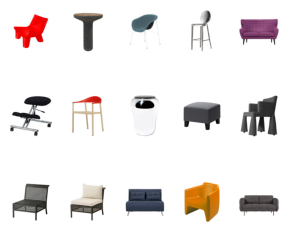

In [4]:
# Initialize Preprocessor
preprocessor = Preprocessor()

# Download Datasets
preprocessor.Run()

# Create category selector (interactive)
# After selecting category, the data will be split and sample images will be shown dynamically.
# Based on selected category network will manipulate images
preprocessor.create_category_selector()


After selecting the category and displaying the samples, run the code in the following block to process the images from the chosen category using the network. If you select a different category, you will need to rerun the below block of code to generate images for the newly selected category.

EPOCH: 1.000  errG: 59.838  errD: 4.417  (10.49s - 199.25s remaining)


EPOCH: 2.000  errG: 30.961  errD: 1.554  (22.62s - 203.62s remaining)


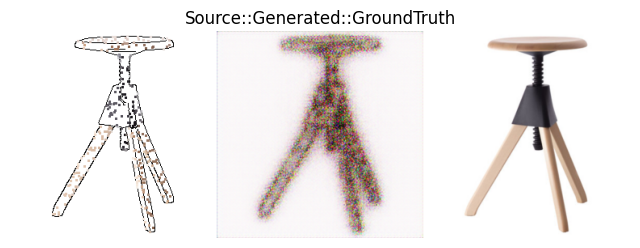

EPOCH: 3.000  errG: 26.641  errD: 1.748  (34.75s - 196.91s remaining)


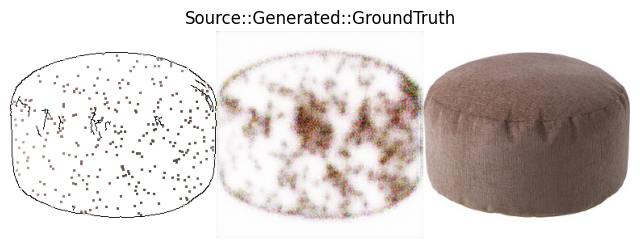

EPOCH: 4.000  errG: 22.334  errD: 1.029  (46.96s - 187.86s remaining)


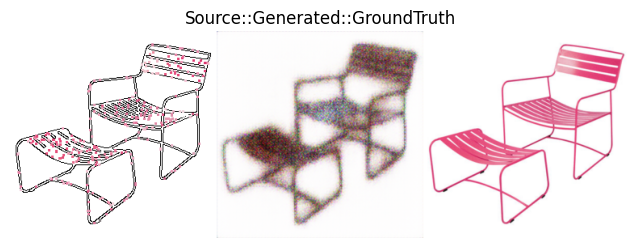

EPOCH: 5.000  errG: 23.020  errD: 0.841  (59.37s - 178.12s remaining)


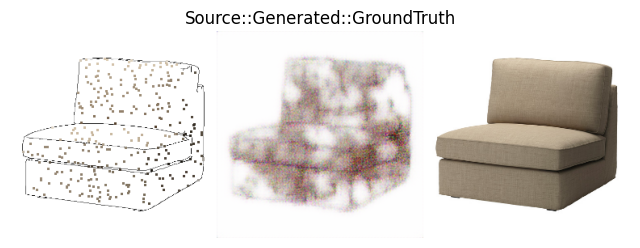

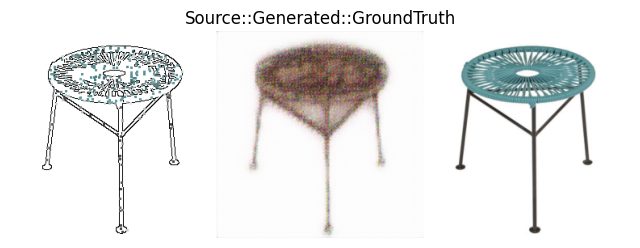

EPOCH: 6.000  errG: 21.154  errD: 1.117  (72.72s - 169.67s remaining)


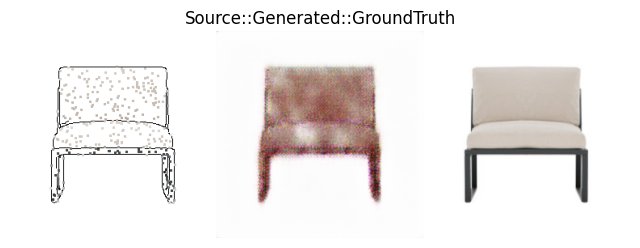

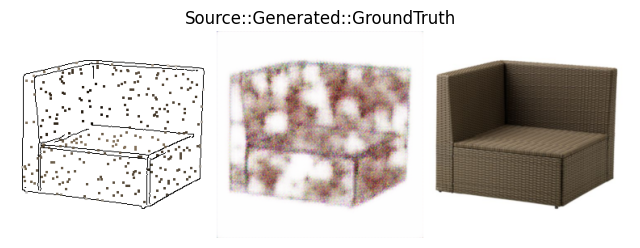

EPOCH: 7.000  errG: 18.961  errD: 0.731  (85.38s - 158.56s remaining)


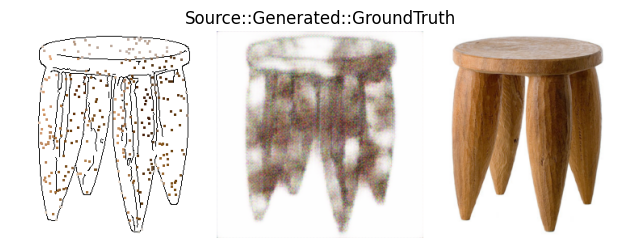

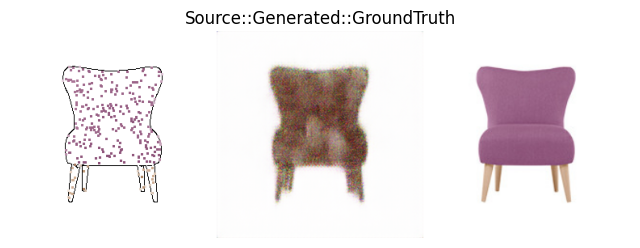

EPOCH: 8.000  errG: 18.017  errD: 0.668  (98.56s - 147.85s remaining)


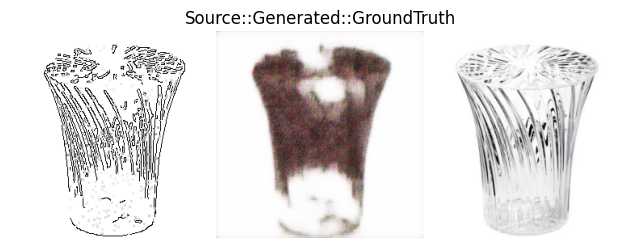

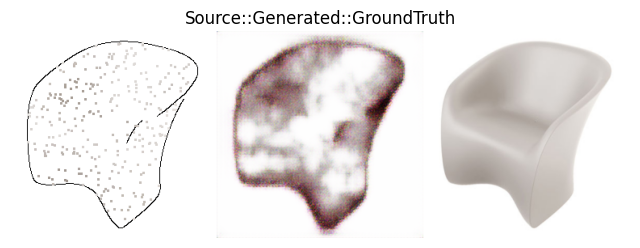

EPOCH: 9.000  errG: 18.480  errD: 0.611  (111.27s - 135.99s remaining)


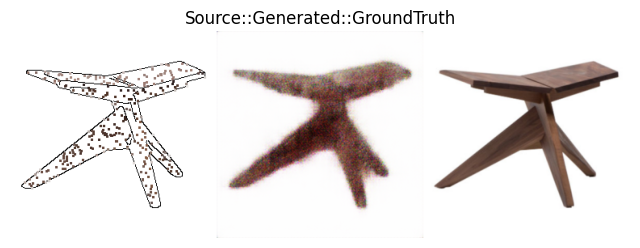

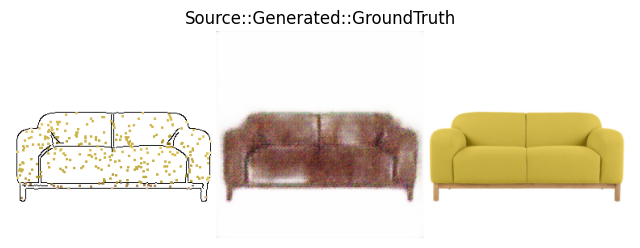

EPOCH: 10.000  errG: 16.650  errD: 0.762  (124.10s - 124.10s remaining)


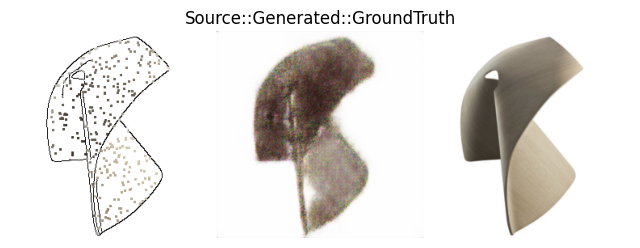

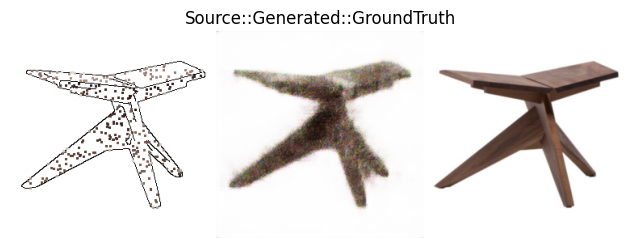

EPOCH: 11.000  errG: 16.713  errD: 0.611  (137.10s - 112.17s remaining)


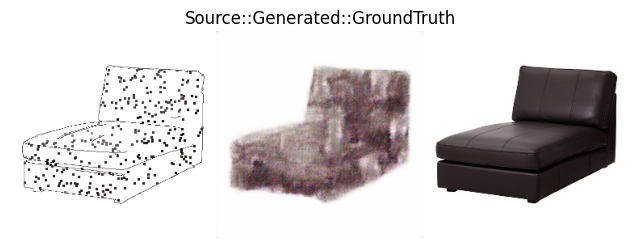

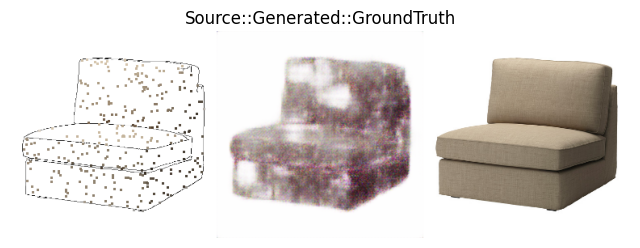

EPOCH: 12.000  errG: 14.498  errD: 0.562  (149.92s - 99.95s remaining)


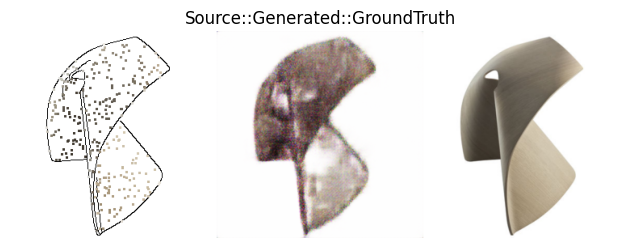

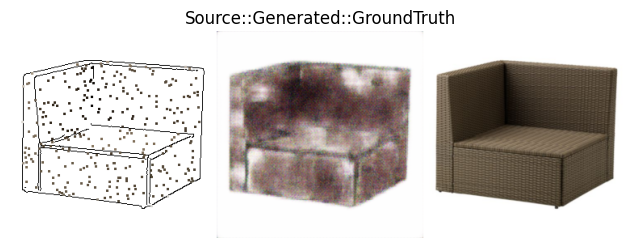

EPOCH: 13.000  errG: 14.254  errD: 0.651  (162.67s - 87.59s remaining)


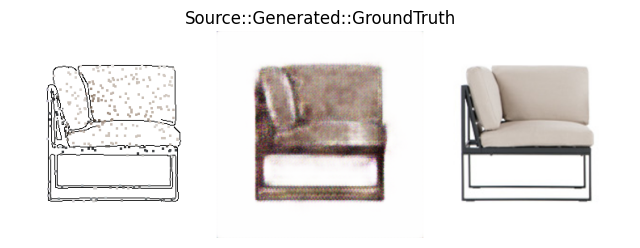

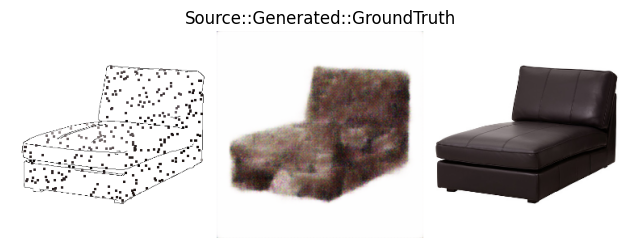

EPOCH: 14.000  errG: 13.254  errD: 0.595  (175.51s - 75.22s remaining)


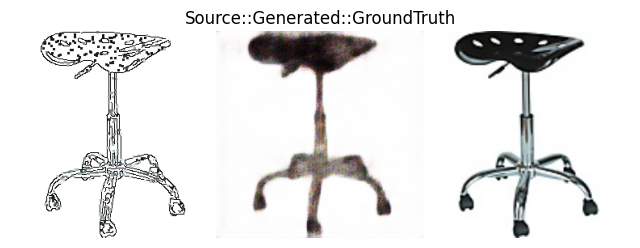

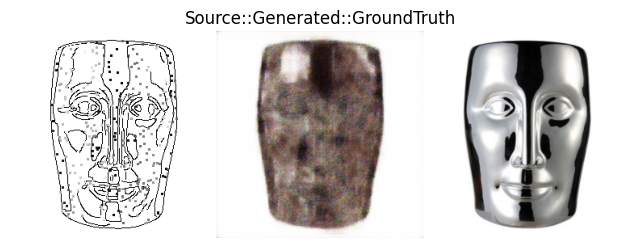

EPOCH: 15.000  errG: 13.608  errD: 0.534  (189.14s - 63.05s remaining)


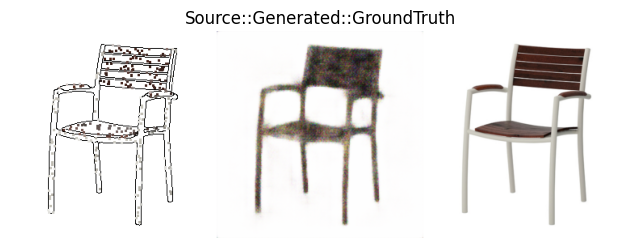

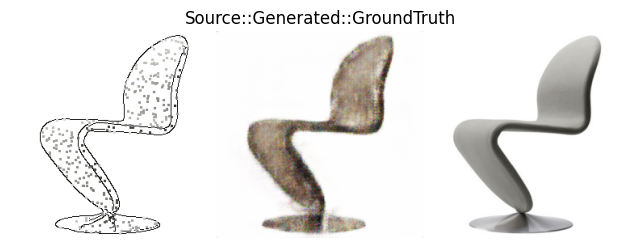

EPOCH: 16.000  errG: 11.514  errD: 0.527  (201.95s - 50.49s remaining)


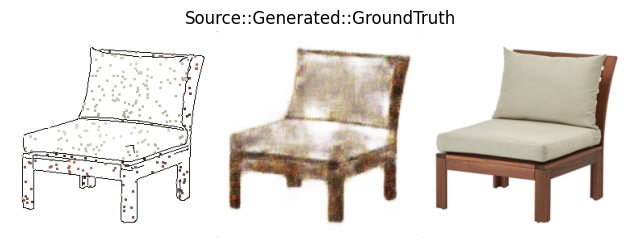

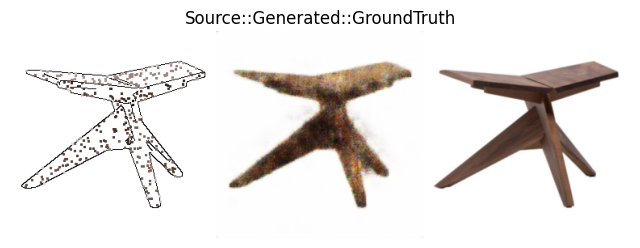

EPOCH: 17.000  errG: 14.443  errD: 0.537  (215.74s - 38.07s remaining)


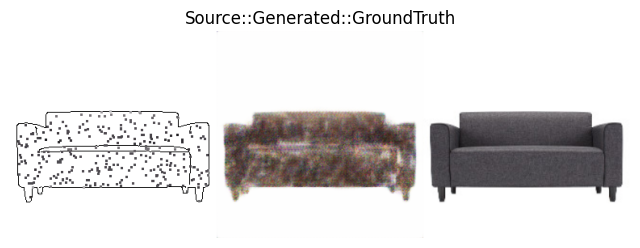

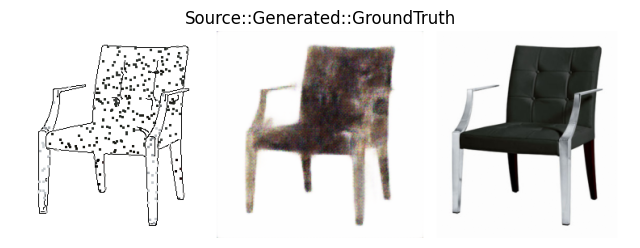

EPOCH: 18.000  errG: 11.323  errD: 0.821  (228.41s - 25.38s remaining)


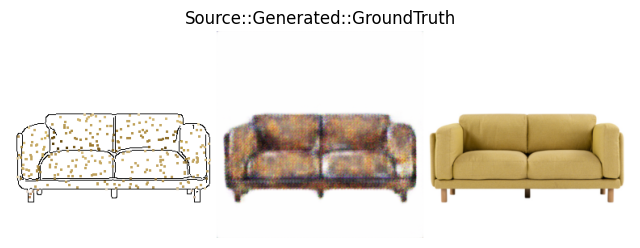

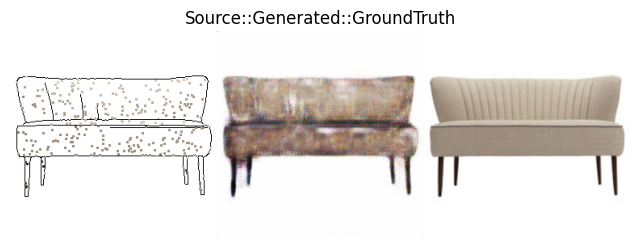

EPOCH: 19.000  errG: 11.038  errD: 0.521  (241.48s - 12.71s remaining)


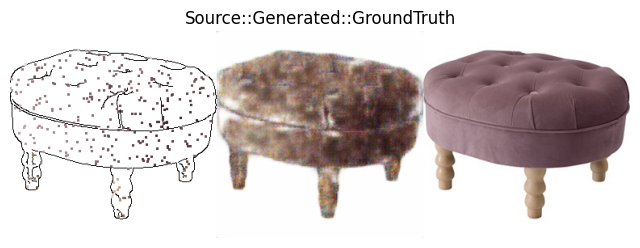

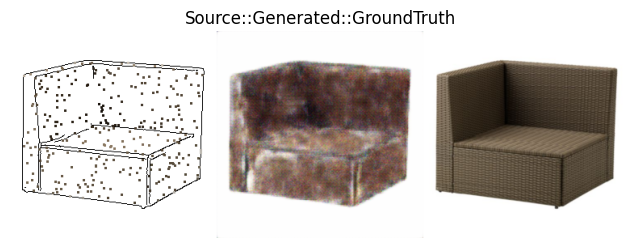

EPOCH: 20.000  errG: 11.077  errD: 0.517  (254.31s - 0.00s remaining)


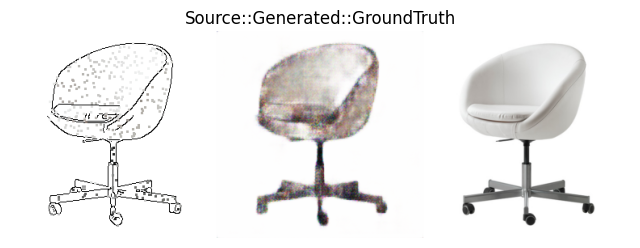

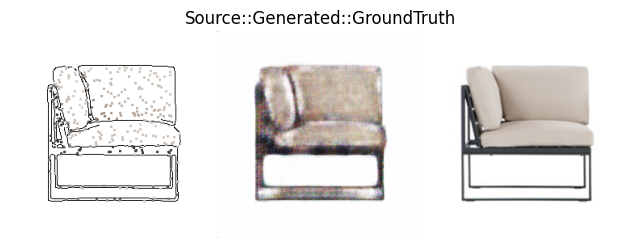

In [6]:
# Create a Model Manager instance
manager = ModelManager(in_channels=3, out_channels=3)

# Forward pass through the generator
input_tensor = torch.randn(1, 3, 256, 256)  # Example input
generated_image = manager.forward_generator(input_tensor)

# Forward pass through the discriminator
real_image = torch.randn(1, 3, 256, 256)  # Example real image
fake_image = generated_image
discriminator_output = manager.forward_discriminator(real_image, fake_image)

# Initialize weights
manager.initialize_weights()

# Access individual models if needed
generator, discriminator = manager.get_models()

# Model Training
trainer = GANTrainer(preprocessor,manager, epochs=20)
trainer.train()

The output consist of
1. Source image - input to network
2. Generated Image - generated based in source image
3. Real Image

The source image may appear to show chickenpox, but in reality, it does not. 🙂 Instead, we sprinkles color patterns from the original images to help the network learn how to blend these colors effectively for generating a new image.